<p style="font-size:20px;">Simulator: QiskitAer, FakeTorino, ideal device noise simulator (no shot noise). H4(rectangular) in minimal basis (STO-3G), JW mapping, 1-layered tUPS. With zero-parameters as well as biasing parameters for training set, number of parameters is 9. Fitting methods: Square regression with a linear ansatz, add-and-subtract.</p>

In [19]:
import pyscf
import slowquant.SlowQuant as sq
from qiskit_nature.second_q.mappers import JordanWignerMapper
from slowquant.qiskit_interface.interface import QuantumInterface
from slowquant.qiskit_interface.wavefunction import WaveFunction
from slowquant.unitary_coupled_cluster.ups_wavefunction import WaveFunctionUPS
#from slowquant.qiskit_interface.linear_response.projected import quantumLR

from qiskit_ibm_runtime.fake_provider import FakeTorino

from qiskit.primitives import Estimator

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.primitives import Sampler
from qiskit_aer.primitives import SamplerV2

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

import numpy as np
from scipy.optimize import minimize
import itertools
import random
from scipy.optimize import curve_fit
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

import matplotlib.pyplot as plt

In [2]:
mol = pyscf.M(atom="""H 0.0 0.0 0.0;
                      H 1.5 0.0 0.0;
                      H 0.0 1.8 0.0;
                      H 1.5 1.8 0.0;""", basis="sto-3g", unit="angstrom")
rhf = pyscf.scf.RHF(mol).run()

sampler = Estimator()
primitive = sampler
mapper = JordanWignerMapper()
# For H4 you can make the wavefunction better by increasing n_layers.
# n_layers: 3 will prob. give almost the FCI solution.
QI = QuantumInterface(primitive, "tUPS", mapper, ansatz_options={"n_layers": 1, "do_pp": True}, ISA = True)

WF = WaveFunction(
    mol.nao * 2,
    mol.nelectron,
    (4, 4),
    rhf.mo_coeff,
    mol.intor("int1e_kin") + mol.intor("int1e_nuc"),
    mol.intor("int2e"),
    QI,
    include_active_kappa = True
)

WF.run_vqe_2step("RotoSolve", maxiter=3)
WF.run_vqe_2step("SLSQP", maxiter=40)
#WF.ansatz_parameters = [3.142800380570141, 2.802123553483023, 3.141844220036336, 3.1415016877195234, 2.7699109323169533, 3.140289037489865, 1.5722892785591813, -0.05183267369041262, -3.139930460730367, -3.05193091891377, 0.07499512879186974, 0.26977250393898994, -2.875485939584386, -0.18478422435886988, 0.21835082743355141, -3.145279642647945, 0.2027868009455131, 3.141049426792193, -2.802097303067954, -0.20245039509840054, 0.14415193008627167, 0.24779481988227897, -0.04867618752527981, -3.0111535837495227, -3.1367777510378136, -0.21605050555915123, -3.14472880076259]
optimized_parameters = WF.ansatz_parameters
#no noise
nonclif_ground_state_energy = WF.energy_elec
print("Non-Clifford Ground state energy:", nonclif_ground_state_energy)

#device noise
# Update the primitive with simulated noise
backend = FakeTorino()
QI.pass_manager = generate_preset_pass_manager(3,backend=backend,seed_transpiler=123) # seeded standard transpiler
QI.do_postselection = False
QI.do_M_mitigation = False
noise_model = NoiseModel.from_backend(backend)
sampler = Sampler(backend_options={"noise_model":noise_model})
WF.change_primitive(sampler)    
# Calculate the ground state energy using the noisy simulator
noisy_nonclif_ground_state_energy = WF.energy_elec
print("Noisy Non-Clifford Ground state energy:",noisy_nonclif_ground_state_energy)

converged SCF energy = -1.77674731624872
Number of shots is None. Ideal simulator is assumed.


/tmp/ipykernel_3732896/3384794756.py:7: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  sampler = Estimator()


You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None with optimization level 3
Full optimization
Iteration # | Iteration time [s] | Electronic energy [Hartree]
--------Ansatz optimization
--------Iteration # | Iteration time [s] | Electronic energy [Hartree]
--------     1      |        16.44       |     -3.5534864780644124    
--------     2      |        14.72       |     -3.5829207745370955    
--------     3      |        14.71       |     -3.5844408545544031    
Full optimization
Iteration # | Iteration time [s] | Electronic energy [Hartree]
--------Ansatz optimization
--------Iteration # | Iteration time [s] | Electronic energy [Hartree]
--------     1      |         5.54       |     -3.5845371986611774    
--------     2      |         5.47       |     -3.5845686528715337    
--------     3      |         5.46       |     -3.5845806681421246    
--------     4      |         5.46       |     -3.5845809600371181    
--------     5

<p style="font-size:20px;">CGBEM Zero Parameters</p>

In [3]:
mol = pyscf.M(atom="""H 0.0 0.0 0.0;
                      H 1.5 0.0 0.0;
                      H 0.0 1.8 0.0;
                      H 1.5 1.8 0.0;""", basis="sto-3g", unit="angstrom")
rhf = pyscf.scf.RHF(mol).run()

primitive = Estimator()
mapper = JordanWignerMapper()
# For H4 you can make the wavefunction better by increasing n_layers.
# n_layers: 3 will prob. give almost the FCI solution.
QI = QuantumInterface(primitive, "tUPS", mapper, ansatz_options={"n_layers": 1, "do_pp": True}, ISA = True)

WF = WaveFunction(
    mol.nao * 2,
    mol.nelectron,
    (4, 4),
    rhf.mo_coeff,
    mol.intor("int1e_kin") + mol.intor("int1e_nuc"),
    mol.intor("int2e"),
    QI,
    include_active_kappa = True
)

print(WF.ansatz_parameters)

clifford_ground_state_energy = WF.energy_elec
print('Clifford ground state energy:', clifford_ground_state_energy)

QI.pass_manager = generate_preset_pass_manager(3,backend=backend,seed_transpiler=123) # seeded standard transpiler
QI.do_postselection = False
QI.do_M_mitigation = False
noise_model = NoiseModel.from_backend(backend)
sampler = Sampler(backend_options={"noise_model":noise_model})
WF.change_primitive(sampler)
noisy_clifford_ground_state_energy = WF.energy_elec
print("Noisy clifford ground state energy:", noisy_clifford_ground_state_energy)


converged SCF energy = -1.77674731624872
Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None with optimization level 3
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Clifford ground state energy: -3.2895813578826005


/tmp/ipykernel_3732896/1707571679.py:7: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  primitive = Estimator()


Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [17, 25, 35, 24, 28, 26, 27, 44]
 Non-local gates:     135
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['sx', 'x', 'id', 'measure', 'reset', 'cz']>)

Noisy clifford ground state energy: -3.164696834996573


In [4]:
CGBEM_Zero = noisy_nonclif_ground_state_energy + clifford_ground_state_energy - noisy_clifford_ground_state_energy
print('AS prediction:', CGBEM_Zero)

AS prediction: -3.4879406676496685


<p style="font-size:20px;">CGBEM Biased Parameters</p>

In [5]:
mol = pyscf.M(atom="""H 0.0 0.0 0.0;
                      H 1.5 0.0 0.0;
                      H 0.0 1.8 0.0;
                      H 1.5 1.8 0.0;""", basis="sto-3g", unit="angstrom")
rhf = pyscf.scf.RHF(mol).run()

sampler = Estimator()
primitive = sampler
mapper = JordanWignerMapper()
# For H4 you can make the wavefunction better by increasing n_layers.
# n_layers: 3 will prob. give almost the FCI solution.
QI = QuantumInterface(primitive, "tUPS", mapper, ansatz_options={"n_layers": 1, "do_pp": True}, ISA = True)

WF = WaveFunction(
    mol.nao * 2,
    mol.nelectron,
    (4, 4),
    rhf.mo_coeff,
    mol.intor("int1e_kin") + mol.intor("int1e_nuc"),
    mol.intor("int2e"),
    QI,
    #include_active_kappa = True
)
WF.ansatz_parameters = optimized_parameters

for i in range(len(optimized_parameters)):
    if 0 < optimized_parameters[i] < np.pi/4:
        WF.ansatz_parameters[i] = 0 
    elif np.pi/4 < optimized_parameters[i] < (np.pi*3)/4:
        WF.ansatz_parameters[i] = np.pi/2
    elif (np.pi*3)/4 < optimized_parameters[i] < (np.pi*5)/4:
        WF.ansatz_parameters[i] = np.pi
    elif (np.pi*5)/4 < optimized_parameters[i] < (np.pi*7)/4:
        WF.ansatz_parameters[i] = (np.pi*3)/2
    elif (np.pi*7)/4 < optimized_parameters[i] < np.pi*2:
        WF.ansatz_parameters[i] = 0
    elif -np.pi/4 < optimized_parameters[i] < 0:
        WF.ansatz_parameters[i] = 0
    elif -(np.pi*3)/4 < optimized_parameters[i] < -np.pi/4:
        WF.ansatz_parameters[i] = -np.pi/2
    elif -(np.pi*5)/4 < optimized_parameters[i] < -(np.pi*3)/4:
        WF.ansatz_parameters[i] = -np.pi
    elif -(np.pi*7)/4 < optimized_parameters[i] < -(np.pi*5)/4:
        WF.ansatz_parameters[i] = -(np.pi*3)/2
    elif -np.pi*2 < optimized_parameters[i] < -(np.pi*7)/4:
        WF.ansatz_parameters[i] = 0
    
    for n in range(9):
        if i == 1 + 3*n:
            m = optimized_parameters[i]/4
            if 0 < m < np.pi/4:
                m = 0
                WF.ansatz_parameters[i] = 4 * m 
            elif np.pi/4 < m < (np.pi*3)/4:
                m = np.pi/2
                WF.ansatz_parameters[i] = 4 * m
            elif (np.pi*3)/4 < m < (np.pi*5)/4:
                m = np.pi
                WF.ansatz_parameters[i] = 4 * m
            elif -np.pi/4 < 0:
                m = 0
                WF.ansatz_parameters[i] = 4 * m
            elif -(np.pi*3)/4 < m < -np.pi/4:
                m = -np.pi/2
                WF.ansatz_parameters[i] = 4 * m
            elif -(np.pi*5)/4 < m < -(np.pi*3)/4:
                m = -np.pi
                WF.ansatz_parameters[i] = 4 * m

print(WF.ansatz_parameters)

clifford_ground_state_energy = WF.energy_elec
print(clifford_ground_state_energy)

backend = FakeTorino()
QI.pass_manager = generate_preset_pass_manager(3,backend=backend,seed_transpiler=123) # seeded standard transpiler
QI.do_postselection = False
QI.do_M_mitigation = False
noise_model = NoiseModel.from_backend(backend)
sampler = Sampler(backend_options={"noise_model":noise_model})
WF.change_primitive(sampler)
noisy_clifford_ground_state_energy = WF.energy_elec
print(noisy_clifford_ground_state_energy)

converged SCF energy = -1.77674731624872
Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None with optimization level 3
[3.141592653589793, 0, 3.141592653589793, 3.141592653589793, 0, -3.141592653589793, 1.5707963267948966, 0, -3.141592653589793]
-3.521986269727307


/tmp/ipykernel_3732896/2116321714.py:7: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  sampler = Estimator()


Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [17, 25, 35, 24, 28, 26, 27, 44]
 Non-local gates:     135
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['sx', 'x', 'id', 'measure', 'reset', 'cz']>)

-3.331842162167099


In [6]:
CGBEM_Bias = noisy_nonclif_ground_state_energy + clifford_ground_state_energy - noisy_clifford_ground_state_energy
print('AS prediction:', CGBEM_Bias)

AS prediction: -3.5532002523238497


<p style="font-size:20px;">CDR Zero</p>

In [12]:
# 给定的9个数（可以根据实际需求更改）
numbers = [0, 1, 2, 3, 4, 5, 6, 7, 8]

# 生成所有可能的三个数的组合
all_combinations = list(itertools.combinations(numbers, 3))

# 随机选择40个不重复的组合
selected_combinations = random.sample(all_combinations, 40)

In [13]:
#prepare training set
clif_ground_state_energies = []
noisy_clif_ground_state_energies = []
n_replacements = 3

for n in range(40):
    QI = QuantumInterface(primitive, "tUPS", mapper, ansatz_options={"n_layers": 1, "do_pp": True}, ISA = True)

    WF = WaveFunction(
    mol.nao * 2,
    mol.nelectron,
    (4, 4),
    rhf.mo_coeff,
    mol.intor("int1e_kin") + mol.intor("int1e_nuc"),
    mol.intor("int2e"),
    QI,
    #include_active_kappa = True
    )

    indices_to_replace = selected_combinations[n]
    for index in indices_to_replace:
        WF.ansatz_parameters[index] = optimized_parameters[index]
    print(WF.ansatz_parameters)

    clif_ground_state_energy = WF.energy_elec
    clif_ground_state_energies.append(clif_ground_state_energy)
    
    backend = FakeTorino()
    QI.pass_manager = generate_preset_pass_manager(3,backend=backend,seed_transpiler=123) # seeded standard transpiler
    QI.do_postselection = False
    QI.do_M_mitigation = False
    noise_model = NoiseModel.from_backend(backend)
    sampler = Sampler(backend_options={"noise_model":noise_model})
    WF.change_primitive(sampler)   
    noisy_clif_ground_state_energy = WF.energy_elec
    noisy_clif_ground_state_energies.append(noisy_clif_ground_state_energy)

Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None with optimization level 3
[0.0, -0.16027725692800446, 0.0, 0.0, -0.1794040406058284, 0.0, 0.0, -0.16028326540412624, 0.0]
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [17, 25, 35, 24, 28, 26, 27, 44]
 Non-local gates:     135
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on [

In [16]:
#data preparation
nonclif_ground_state_energies = [nonclif_ground_state_energy for _ in range(len(clif_ground_state_energies))]
noisy_nonclif_ground_state_energies = [noisy_nonclif_ground_state_energy for _ in range(len(noisy_clif_ground_state_energies))]
X = np.array(noisy_clif_ground_state_energies).reshape(-1, 1)
y = np.array(clif_ground_state_energies)
X_test = np.array(noisy_nonclif_ground_state_energies).reshape(-1, 1)
y_test = np.array(nonclif_ground_state_energies)

In [17]:
#square regression with a linear ansatz
def cost_function(a, X_exact, X_noisy):
    a1, a2 = a  # 将参数 a 拆分为 a1 和 a2
    # 计算代价函数 C 的值
    C = np.sum((X_exact - (a1 * X_noisy + a2))**2)
    return C
X_exact = np.array(clif_ground_state_energies)
X_noisy = np.array(noisy_clif_ground_state_energies)
# 初始猜测值 a1 和 a2
initial_guess = [1, 0]
# 最小化代价函数
result = minimize(cost_function, initial_guess, args=(X_exact, X_noisy))
# 得到最优的 a1 和 a2
a1_optimal, a2_optimal = result.x
#print(f"最优的 a1 值: {a1_optimal}")
#print(f"最优的 a2 值: {a2_optimal}")
y_CDRZERO_linear = a1_optimal*noisy_nonclif_ground_state_energy + a2_optimal
print('result of square regression:', y_CDRZERO_linear)

result of square regression: -3.5748426352637903


In [20]:
#Nonlinear Fitting
# 定义非线性拟合函数
def nonlinear_model(X_noisy, a1, a2, a3):
    return a1 * X_noisy**2 + a2 * X_noisy + a3

# 输入数据
X_exact = np.array(clif_ground_state_energies)
X_noisy = np.array(noisy_clif_ground_state_energies)

# 使用 curve_fit 进行非线性拟合
# 初始猜测值 [a1, a2, a3]
initial_guess = [1, 1, 0]
params, covariance = curve_fit(nonlinear_model, X_noisy, X_exact, p0=initial_guess)

# 提取拟合参数
a1_optimal, a2_optimal, a3_optimal = params
#print(f"最优的 a1 值: {a1_optimal}")
#print(f"最优的 a2 值: {a2_optimal}")
#print(f"最优的 a3 值: {a3_optimal}")

# 对新的数据进行预测
y_CDRZERO_nonlinear = nonlinear_model(noisy_nonclif_ground_state_energy, a1_optimal, a2_optimal, a3_optimal)
print('Result of Nonlinear Fitting:', y_CDRZERO_nonlinear)

Result of Nonlinear Fitting: -3.5622703654742764


In [21]:
#XGBoost
xgb_model = XGBRegressor(max_depth=20, eta=0.0005, subsample=0.7, colsample_bytree=0.7, objective='reg:absoluteerror', n_estimators=1000, random_state=42)
xgb_model.fit(X, y)
y_CDRZERO_xgb = xgb_model.predict(X_test)
# 计算均方误差
#mse_corrected_XGB = mean_squared_error(y_test, y_pred_xgb)
#print('mse:', mse_corrected_XGB)
print('result of xgb:', y_CDRZERO_xgb[0])

result of xgb: -3.3898072


In [22]:
#MLP
# 归一化数据
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# 训练MLP模型
mlp_model = MLPRegressor(hidden_layer_sizes=(120, 60), activation='relu', solver='adam', max_iter=2000, alpha=0.001, random_state=42)
mlp_model.fit(X_scaled, y)
X_test_scaled = scaler.transform(X_test)
y_CDRZERO_mlp = mlp_model.predict(X_test_scaled)
#mse_corrected_MLP = mean_squared_error(y_test, y_pred_mlp)
#print('mse:', mse_corrected_MLP)
print('result of mlp:', y_CDRZERO_mlp[0])

result of mlp: -3.8065661594579447


<p style="font-size:20px;">CDR Biased</p>

In [23]:
#prepare training set
clif_ground_state_energies = []
noisy_clif_ground_state_energies = []
n_replacements = 3

for n in range(40):
    QI = QuantumInterface(primitive, "tUPS", mapper, ansatz_options={"n_layers": 1, "do_pp": True}, ISA = True)

    WF = WaveFunction(
    mol.nao * 2,
    mol.nelectron,
    (4, 4),
    rhf.mo_coeff,
    mol.intor("int1e_kin") + mol.intor("int1e_nuc"),
    mol.intor("int2e"),
    QI,
    #include_active_kappa = True
    )
    WF.ansatz_parameters = [3.141592653589793, 0, 3.141592653589793, 3.141592653589793, 0, 3.141592653589793, -1.5707963267948966, 0, 3.141592653589793]
    
    indices_to_replace = selected_combinations[n]
    for index in indices_to_replace:
        WF.ansatz_parameters[index] = optimized_parameters[index]
    print(WF.ansatz_parameters)

    clif_ground_state_energy = WF.energy_elec
    clif_ground_state_energies.append(clif_ground_state_energy)
    
    backend = FakeTorino()
    QI.pass_manager = generate_preset_pass_manager(3,backend=backend,seed_transpiler=123) # seeded standard transpiler
    QI.do_postselection = False
    QI.do_M_mitigation = False
    noise_model = NoiseModel.from_backend(backend)
    sampler = Sampler(backend_options={"noise_model":noise_model})
    WF.change_primitive(sampler)   
    noisy_clif_ground_state_energy = WF.energy_elec
    noisy_clif_ground_state_energies.append(noisy_clif_ground_state_energy)

Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None with optimization level 3
[3.141592653589793, -0.16027725692800446, 3.141592653589793, 3.141592653589793, -0.1794040406058284, 3.141592653589793, -1.5707963267948966, -0.16028326540412624, 3.141592653589793]
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [17, 25, 35, 24, 28, 26, 27, 44]
 Non-local gates:     135
 Transpilation strategy: External PassManager
 Primi

In [24]:
#data preparation
nonclif_ground_state_energies = [nonclif_ground_state_energy for _ in range(len(clif_ground_state_energies))]
noisy_nonclif_ground_state_energies = [noisy_nonclif_ground_state_energy for _ in range(len(noisy_clif_ground_state_energies))]
X = np.array(noisy_clif_ground_state_energies).reshape(-1, 1)
y = np.array(clif_ground_state_energies)
X_test = np.array(noisy_nonclif_ground_state_energies).reshape(-1, 1)
y_test = np.array(nonclif_ground_state_energies)

In [25]:
#square regression with a linear ansatz
def cost_function(a, X_exact, X_noisy):
    a1, a2 = a  # 将参数 a 拆分为 a1 和 a2
    # 计算代价函数 C 的值
    C = np.sum((X_exact - (a1 * X_noisy + a2))**2)
    return C
X_exact = np.array(clif_ground_state_energies)
X_noisy = np.array(noisy_clif_ground_state_energies)
# 初始猜测值 a1 和 a2
initial_guess = [1, 0]
# 最小化代价函数
result = minimize(cost_function, initial_guess, args=(X_exact, X_noisy))
# 得到最优的 a1 和 a2
a1_optimal, a2_optimal = result.x
#print(f"最优的 a1 值: {a1_optimal}")
#print(f"最优的 a2 值: {a2_optimal}")
y_CDRBIASED_linear = a1_optimal*noisy_nonclif_ground_state_energy + a2_optimal
print('result of square regression:', y_CDRBIASED_linear)

result of square regression: -3.584676553650363


In [26]:
#Nonlinear Fitting
# 定义非线性拟合函数
def nonlinear_model(X_noisy, a1, a2, a3):
    return a1 * X_noisy**2 + a2 * X_noisy + a3

# 输入数据
X_exact = np.array(clif_ground_state_energies)
X_noisy = np.array(noisy_clif_ground_state_energies)

# 使用 curve_fit 进行非线性拟合
# 初始猜测值 [a1, a2, a3]
initial_guess = [1, 1, 0]
params, covariance = curve_fit(nonlinear_model, X_noisy, X_exact, p0=initial_guess)

# 提取拟合参数
a1_optimal, a2_optimal, a3_optimal = params
#print(f"最优的 a1 值: {a1_optimal}")
#print(f"最优的 a2 值: {a2_optimal}")
#print(f"最优的 a3 值: {a3_optimal}")

# 对新的数据进行预测
y_CDRBIASED_nonlinear = nonlinear_model(noisy_nonclif_ground_state_energy, a1_optimal, a2_optimal, a3_optimal)
print('Result of Nonlinear Fitting:', y_CDRBIASED_nonlinear)

Result of Nonlinear Fitting: -3.5838815057455733


In [27]:
#XGBoost
xgb_model = XGBRegressor(max_depth=20, eta=0.0005, subsample=0.7, colsample_bytree=0.7, objective='reg:absoluteerror', n_estimators=1000, random_state=42)
xgb_model.fit(X, y)
y_CDRBIASED_xgb = xgb_model.predict(X_test)
# 计算均方误差
#mse_corrected_XGB = mean_squared_error(y_test, y_pred_xgb)
#print('mse:', mse_corrected_XGB)
print('result of xgb:', y_CDRBIASED_xgb[0])

result of xgb: -3.5564628


In [28]:
#MLP
# 归一化数据
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# 训练MLP模型
mlp_model = MLPRegressor(hidden_layer_sizes=(120, 60), activation='relu', solver='adam', max_iter=2000, alpha=0.001, random_state=42)
mlp_model.fit(X_scaled, y)
X_test_scaled = scaler.transform(X_test)
y_CDRBIASED_mlp = mlp_model.predict(X_test_scaled)
#mse_corrected_MLP = mean_squared_error(y_test, y_pred_mlp)
#print('mse:', mse_corrected_MLP)
print('result of mlp:', y_CDRBIASED_mlp[0])

result of mlp: -3.824712030117197


In [30]:
delta_CBGEM_zero = nonclif_ground_state_energy - CGBEM_Zero
delta_CBGEM_bias = nonclif_ground_state_energy - CGBEM_Bias
delta_CDRlinear_zero = nonclif_ground_state_energy - y_CDRZERO_linear
delta_CDRnonlinear_zero = nonclif_ground_state_energy - y_CDRZERO_nonlinear
delta_CDRxgb_zero = nonclif_ground_state_energy - y_CDRZERO_xgb[0]
delta_CDRlmlp_zero = nonclif_ground_state_energy - y_CDRZERO_mlp[0]
delta_CDRlinear_bias = nonclif_ground_state_energy - y_CDRBIASED_linear
delta_CDRnonlinear_bias = nonclif_ground_state_energy - y_CDRBIASED_nonlinear
delta_CDRxgb_bias = nonclif_ground_state_energy - y_CDRBIASED_xgb[0]
delta_CDRlmlp_bias = nonclif_ground_state_energy - y_CDRBIASED_mlp[0]
print('CBGEM_zero', delta_CBGEM_zero)
print('CBGEM_bias', delta_CBGEM_bias)
print('CDRlinear_zero', delta_CDRlinear_zero)
print('CDRnonlinear_zero', delta_CDRnonlinear_zero)
print('CDRxgb_zero', delta_CDRxgb_zero)
print('CDRlmlp_zero', delta_CDRlmlp_zero)
print('CDRlinear_bias', delta_CDRlinear_bias)
print('CDRnonlinear_bias', delta_CDRnonlinear_bias)
print('CDRxgb_bias', delta_CDRxgb_bias)
print('CDRlmlp_bias', delta_CDRlmlp_bias)

CBGEM_zero -0.0966402992421096
CBGEM_bias -0.03138071456792835
CDRlinear_zero -0.009738331627987762
CDRnonlinear_zero -0.02231060141750163
CDRxgb_zero -0.19477374261809643
CDRlmlp_zero 0.22198519256616667
CDRlinear_bias 9.558675858478693e-05
CDRnonlinear_bias -0.0006994611462047828
CDRxgb_bias -0.02811820215178784
CDRlmlp_bias 0.240131063225419


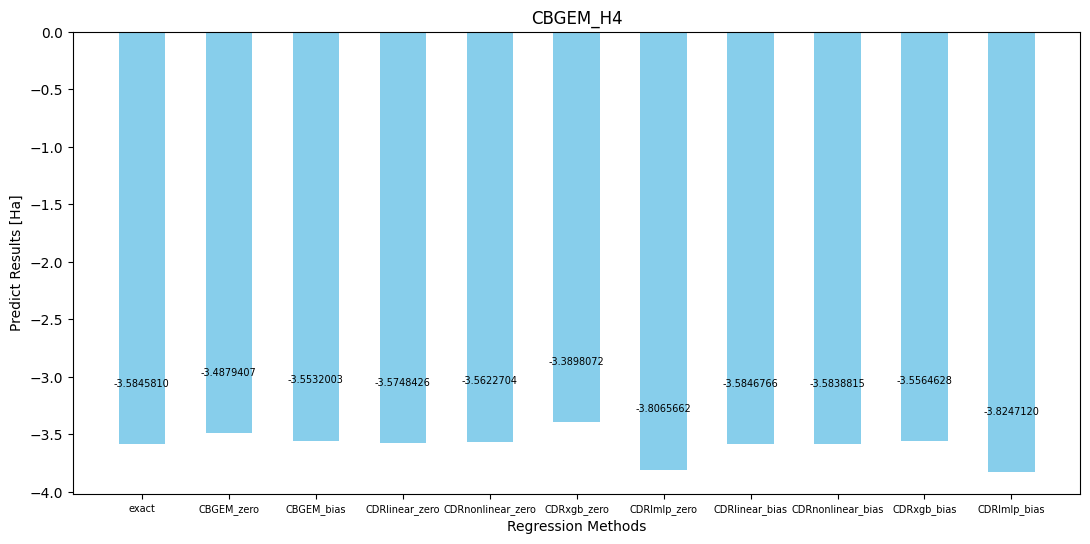

In [62]:
# 数据
categories = ['exact', 'CBGEM_zero', 'CBGEM_bias', 'CDRlinear_zero', 'CDRnonlinear_zero', 'CDRxgb_zero', 'CDRlmlp_zero', 'CDRlinear_bias', 'CDRnonlinear_bias', 'CDRxgb_bias', 'CDRlmlp_bias']
values = [nonclif_ground_state_energy, CGBEM_Zero, CGBEM_Bias, y_CDRZERO_linear, y_CDRZERO_nonlinear, y_CDRZERO_xgb[0], y_CDRZERO_mlp[0], y_CDRBIASED_linear, y_CDRBIASED_nonlinear, y_CDRBIASED_xgb[0], y_CDRBIASED_mlp[0]]
plt.figure(figsize=(13, 6))
# 创建 x 的位置，间距更大
x_positions = np.arange(len(categories)) * 1.5  # 原间距扩大到1.5倍
# 设置 x 轴的刻度和标签
plt.xticks(x_positions, categories, fontsize=7)  # 保持标签的字体大小
# 绘制柱状图
plt.bar(x_positions, values, color='skyblue')

# 添加标题和标签
plt.title('CBGEM_H4')
plt.xlabel('Regression Methods')
plt.ylabel('Predict Results [Ha]')


for i, v in enumerate(values):
    plt.text(x_positions[i], v + 0.5, f"{v:.7f}", ha='center', fontsize=7)

# 显示图表
plt.show()